In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform


In [157]:
# Load the data
features_raw = pd.read_csv('../dataset/x_train_T9QMMVq.csv',index_col=False).drop('ID',axis=1)
labels_raw = pd.read_csv('../dataset/y_train_R0MqWmu.csv').drop('ID', axis=1)

In [158]:
labels_raw

,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,...,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.176471,0.176471,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.176471,0.000000,0.0,0.176471,0.000000
2,0.128465,0.000000,0.128465,0.128465,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.128465,0.000000,0.000000,0.0,0.128465,0.000000
3,0.000000,0.000000,0.263736,0.263736,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.263736,0.263736
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202928,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
202929,0.142857,0.000000,0.142857,0.142857,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.142857,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.000000
202930,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
202931,0.528846,0.000000,0.528846,0.528846,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.528846,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.528846,0.000000


In [159]:
print(features_raw.shape)
print(labels_raw.shape)

(202933, 13)
(202933, 23)


## Seeking structure on the input

#### Study the input correlation matrix

In [160]:
corr_features = features_raw.corr()

/home/jaime/miniconda3/envs/gas_challenge/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


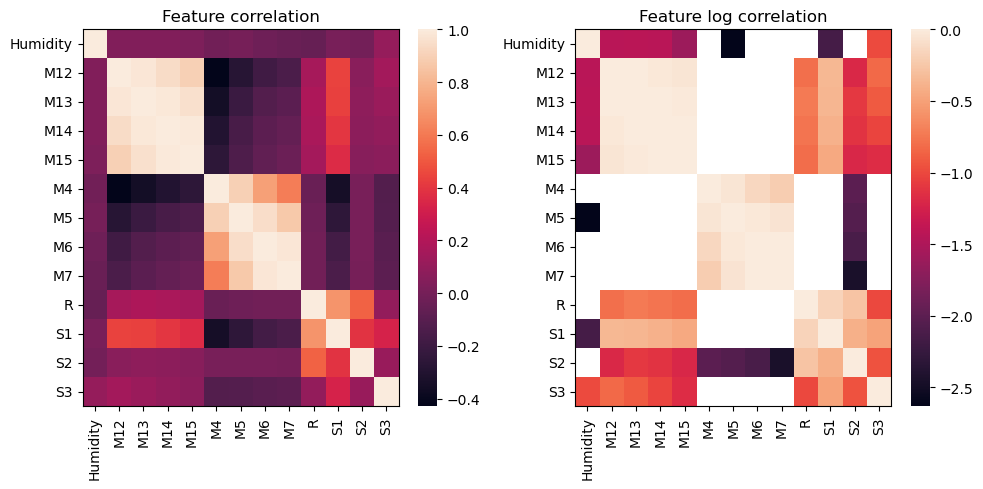

In [161]:
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(corr_features,ax=ax[0])#, annot=True)
sns.heatmap(np.log10(corr_features),ax=ax[1])#, annot=True)
ax[0].set_title('Feature correlation')
ax[1].set_title('Feature log correlation')
f.tight_layout()

for subplot_ax in ax:
    for spine in subplot_ax.spines.values():
        spine.set_visible(True)

#f.savefig('new_corr_plots.png',bbox_inches='tight')

#### Analysis
It seems that there is block structure in the input, that may be useful to diagonalize to extract reduced dimensionality features.

We do a hierarchical clustering to be sure that the blocks that we see are the best blocks possible

In [162]:
features_subset = features_raw.sample(n=10000, random_state=12) #We take a random subset of the dataset to be able to do clustering
features_subset.shape
subset_correlation = features_subset.corr()
distance_matrix = np.ones(np.shape(subset_correlation))-subset_correlation

In [163]:
silhouette_values = []
range_nclusters = range(2,10)
features_subset_np = features_subset.to_numpy().T
for i in range_nclusters:
    hie_clusterer = AgglomerativeClustering(n_clusters=i, metric='precomputed',linkage='complete')
    labels = hie_clusterer.fit_predict(distance_matrix)
    sil = silhouette_score(features_subset_np, labels)
    print(labels)
    silhouette_values.append((i,sil))


silhouette_values = np.array(silhouette_values)

[0 1 1 1 1 0 0 0 0 1 1 1 1]
[2 0 0 0 0 1 1 1 1 0 0 0 0]
[2 3 3 3 3 1 1 1 1 0 0 0 0]
[2 3 3 3 3 1 1 1 1 0 0 0 4]
[5 3 3 3 3 0 0 0 0 1 1 2 4]
[5 3 3 3 3 1 1 2 2 0 0 6 4]
[5 1 1 1 1 0 0 2 2 7 3 6 4]
[5 0 0 0 0 8 4 2 2 7 3 6 1]


In [164]:
silhouette_values

array([[ 2.00000000e+00,  1.73405107e-01],
       [ 3.00000000e+00, -1.48040598e-01],
       [ 4.00000000e+00,  4.76326722e-02],
       [ 5.00000000e+00,  7.78797145e-03],
       [ 6.00000000e+00,  1.74120332e-03],
       [ 7.00000000e+00,  9.37109353e-02],
       [ 8.00000000e+00,  1.62788013e-01],
       [ 9.00000000e+00,  1.40394738e-01]])

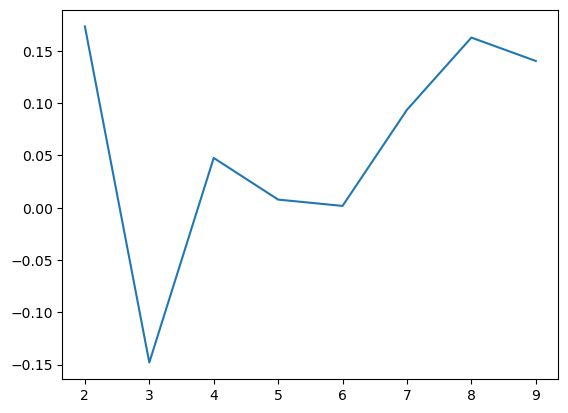

In [165]:
plt.plot(silhouette_values[:,0],silhouette_values[:,1])

In [166]:
dist_squareform = squareform(distance_matrix)
linked = linkage(dist_squareform,method='complete')

/tmp/ipykernel_31521/3077722423.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


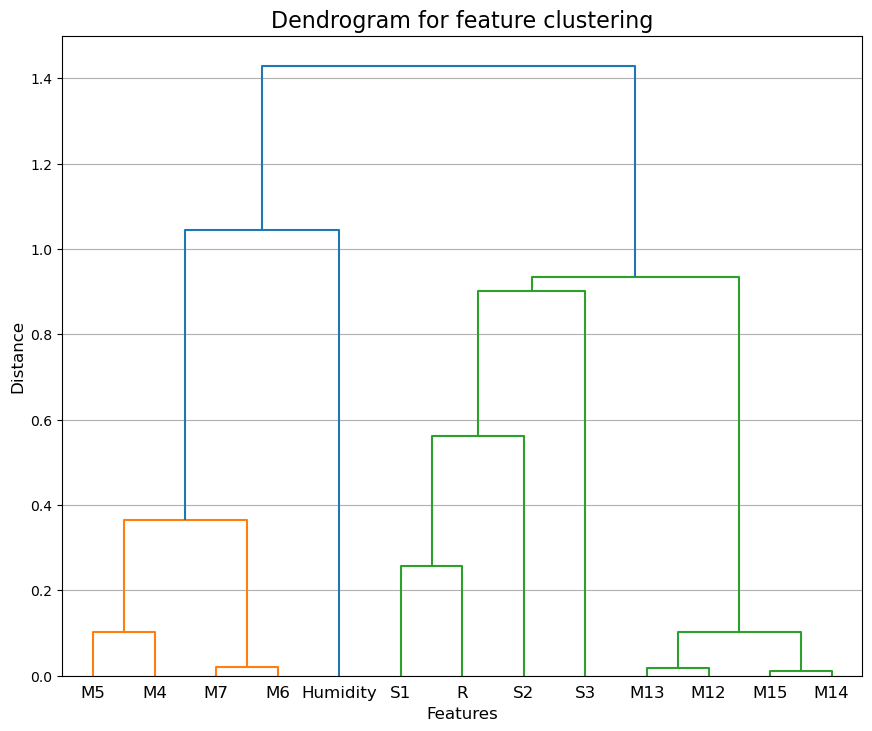

In [ ]:
f = plt.figure(figsize=(10, 8))
ax = f.add_axes((0.1,0.1,0.8,0.8))
dendrogram(linked,
            orientation='top',
            labels=subset_correlation.columns.to_list(),
            distance_sort='descending',
            show_leaf_counts=True,
            ax=ax)
plt.title('Dendrogram for feature clustering', fontsize=16)
plt.ylabel('Distance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

